In [18]:

import numpy as np
import cv2
from scipy.spatial.distance import cdist

def find_best_matching_indices_knn(points1, points2, threshold, k=3):
    distances = cdist(points1, points2)
    best_indices = np.argsort(distances, axis=1)[:, :k]
    best_distances = np.take_along_axis(distances, best_indices, axis=1)

    matched = []

    for i in range(len(points1)):
        min_distance = np.min(best_distances[i])
        if min_distance < threshold:
            best_index = np.argmin(best_distances[i])
            matched.append((i, best_indices[i, best_index]))

    return matched


def find_matching_in_batch(batch_points1, batch_points2, threshold):
    # Lista para armazenar as correspondências
    lista_correspondencias = []

    # Iterar sobre o lote de pontos
    for i in range(batch_points1.shape[0]):
        # Obter os pontos correspondentes entre duas imagens
        correspondencias = find_best_matching_indices_knn(batch_points1[i], batch_points2[i], threshold)
        lista_correspondencias.append(correspondencias)

    return lista_correspondencias

def evaluates_repeatability(_kp1, _kp2,batch_size=1):
    
    lista_correspondencias = find_matching_in_batch(_kp1, _kp2, 2.5)
    num_matchs = 0
    num_matchs_with_outliers = 0
    for i in range(batch_size):
        
        print(_kp1.shape, _kp2.shape)
        pts1 = np.array([_kp1[i, match[0]] for match in lista_correspondencias[i]])
        pts2 = np.array([_kp2[i, match[1]] for match in lista_correspondencias[i]])
        num_matchs += len(lista_correspondencias[i])
        
        print("Quant. de correspondecias Posicionais: {}".format(num_matchs))
        
        # Calcular a matriz fundamental usando o método RANSAC
        fundamental_matrix, mask = cv2.findFundamentalMat(pts1, pts2, method=cv2.FM_RANSAC, ransacReprojThreshold=1.0)
        print("Fundamental Matrix:")
        print(fundamental_matrix)
        # Filtrar os pontos correspondentes com base na máscara
        pts1_filtered = pts1[mask.ravel().astype(bool)]
        pts2_filtered = pts2[mask.ravel().astype(bool)]
        num_matchs_with_outliers += mask.ravel().astype(bool).sum()
        print("Correspondencias sem outliers {}".format(num_matchs_with_outliers))
        


In [30]:
def plot_matches_keypoints(image1, keypoints1, image2, keypoints2, matches, **kwargs):
    # Concatenar as duas imagens lado a lado
    combined_image = np.concatenate((image1.cpu(), image2.cpu()), axis=1)

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.imshow(combined_image, cmap='gray')
    ax.axis('off')

    # Desenhar pontos correspondentes e linhas conectando-os
    offset = image1.shape[1]

    for i, (x, y) in enumerate(keypoints1.cpu()):
        ax.plot(x, y, 'o',markerfacecolor='none', markeredgecolor='g',
                markersize=20, markeredgewidth=1)
        ax.annotate(str(i), (x, y), color='g',xytext=(10, 10), textcoords='offset points', fontsize=12)

    for i, (x, y) in enumerate(keypoints2.cpu()):
        ax.plot(x+offset, y, 'o',markerfacecolor='none', markeredgecolor='g',
                markersize=20, markeredgewidth=1)
        ax.annotate(str(i), (x+offset, y), color='g',xytext=(10, 10), textcoords='offset points', fontsize=12)
    try:
        for match in matches:
            x1, y1 = keypoints1[match[0],0], keypoints1[match[0],1]
            x2, y2 = keypoints2[match[1],0]+offset, keypoints2[match[1],1]
            ax.plot([x1, x2], [y1, y2], '-', color='lime', lw=0.5)
    except:
        print("Erro ao plotar correspondencias")

    plt.tight_layout()
    plt.show()

In [3]:

import torch
import random
import numpy as np
import kornia.augmentation as KA
from torchvision.transforms import transforms, InterpolationMode

PONTOS = 10
BATCH = 2

# Definir a semente
def seed_everything(seed=123):
    torch.manual_seed(seed) # Definir a semente para PyTorch
    random.seed(seed)# Definir a semente para o módulo random do Python
    np.random.seed(seed)# Definir a semente para o módulo numpy
    
data_augmentation = KA.AugmentationSequential(
    KA.RandomAffine(degrees=180, translate=(0.1, 0.1), scale=(0.95, 1.05), shear=10, p=0.8),
    KA.RandomHorizontalFlip(p=0.5),
    KA.RandomVerticalFlip(p=0.5),
    same_on_batch=False,
    data_keys=["input", "keypoints"]
)

def laf_to_xy(lafs):
    xy = torch.zeros((lafs.shape[0],lafs.shape[1], 2))
    xy[:,:, 0] = lafs[:,:,0, 2]
    xy[:,:, 1] = lafs[:,:,1, 2]
    return xy

torch.Size([1, 93, 2]) torch.Size([1, 93, 2]) <class 'torch.Tensor'>
(1, 93, 2) (1, 93, 2)
Quant. de correspondecias Posicionais: 9
Fundamental Matrix:
[[ 1.39896929e-05  1.23313573e-04  5.36051438e-02]
 [ 2.49851319e-05  1.72062378e-05  4.43945985e-03]
 [-6.80311831e-02 -1.77450376e-02  1.00000000e+00]]
Correspondencias sem outliers 7
tensor([[ 76.6864,  80.2367],
        [ 10.6509,  48.2840],
        [ 78.8166,  88.7574],
        [ 78.8166,  63.9053],
        [101.5385,  56.0947]], grad_fn=<SliceBackward0>)
Erro ao plotar correspondencias


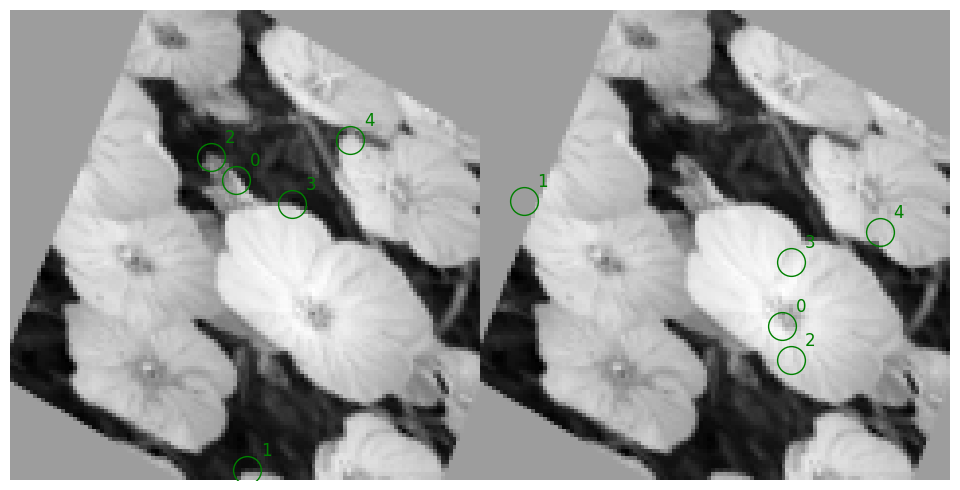

torch.Size([1, 110, 2]) torch.Size([1, 110, 2]) <class 'torch.Tensor'>
(1, 110, 2) (1, 110, 2)
Quant. de correspondecias Posicionais: 16
Fundamental Matrix:
[[ 1.76361466e-05  1.91282091e-03 -1.20345103e-01]
 [-1.79954336e-03  5.98665334e-05  1.14440731e-01]
 [ 1.07479115e-01 -1.29319742e-01  1.00000000e+00]]
Correspondencias sem outliers 13
tensor([[ 68.1657,  22.0118],
        [101.5385,  46.8639],
        [ 90.8876,  95.1479],
        [ 90.1775,  77.3964],
        [ 96.5680,  62.4852]], grad_fn=<SliceBackward0>)
Erro ao plotar correspondencias


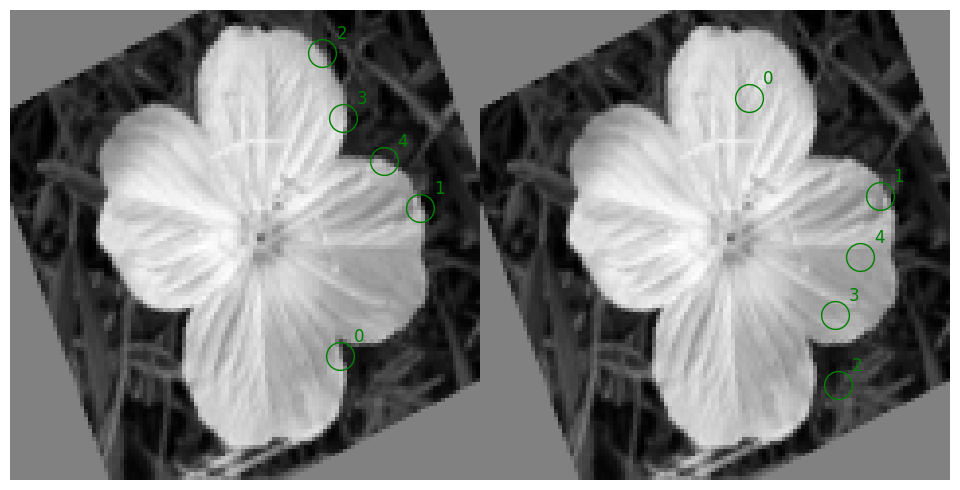

torch.Size([1, 102, 2]) torch.Size([1, 102, 2]) <class 'torch.Tensor'>
(1, 102, 2) (1, 102, 2)
Quant. de correspondecias Posicionais: 102
Fundamental Matrix:
[[ 1.50716835e-19 -1.46260981e-03  1.49000906e-01]
 [ 1.46260981e-03  3.54628986e-20 -2.45837292e-02]
 [-1.49000906e-01  2.45837292e-02  0.00000000e+00]]
Correspondencias sem outliers 102
tensor([[ 48.9941,  64.6154],
        [102.9586,  81.6568],
        [ 89.4675, 101.5385],
        [ 58.2249,  61.7751],
        [100.1183,  89.4675]], grad_fn=<SliceBackward0>)
Erro ao plotar correspondencias


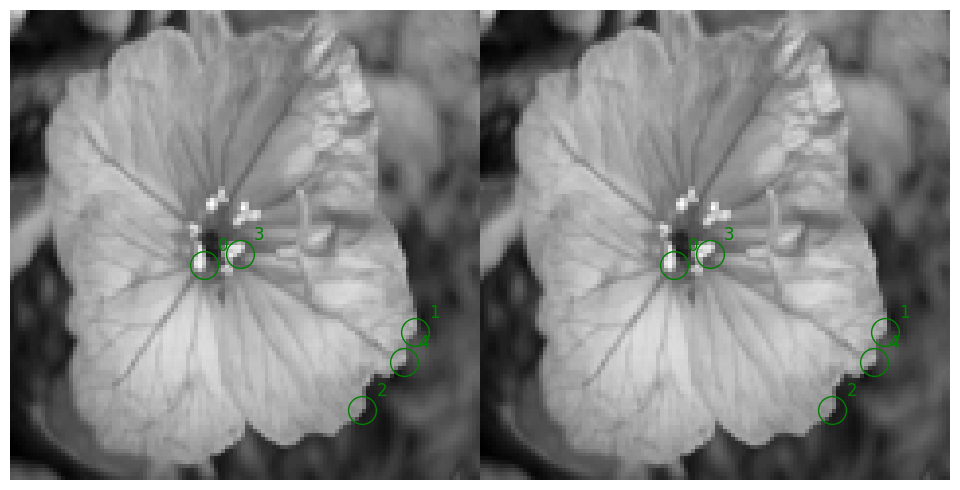

torch.Size([1, 82, 2]) torch.Size([1, 82, 2]) <class 'torch.Tensor'>
(1, 82, 2) (1, 82, 2)
Quant. de correspondecias Posicionais: 7
Fundamental Matrix:
[[ 2.38842503e-04  4.77803760e-03 -1.72554902e-01]
 [-4.77803760e-03  1.17107008e-04  2.80022715e-01]
 [ 1.44132644e-01 -2.88563759e-01  1.00000000e+00]
 [ 6.68533863e-05  8.21928992e-03 -1.16600866e-01]
 [-8.21928992e-03  8.55846775e-04  4.55347816e-01]
 [ 1.08645313e-01 -5.22747684e-01  1.00000000e+00]
 [ 3.48471295e-04  2.58452478e-03 -2.08220957e-01]
 [-2.58452478e-03 -3.53778296e-04  1.68267510e-01]
 [ 1.66752873e-01 -1.39290938e-01  1.00000000e+00]]
Correspondencias sem outliers 7
tensor([[ 90.8876,  45.4438],
        [ 24.1420,  97.9882],
        [105.0888, 105.0888],
        [ 86.6272,  68.8757],
        [ 81.6568,  25.5621]], grad_fn=<SliceBackward0>)
Erro ao plotar correspondencias


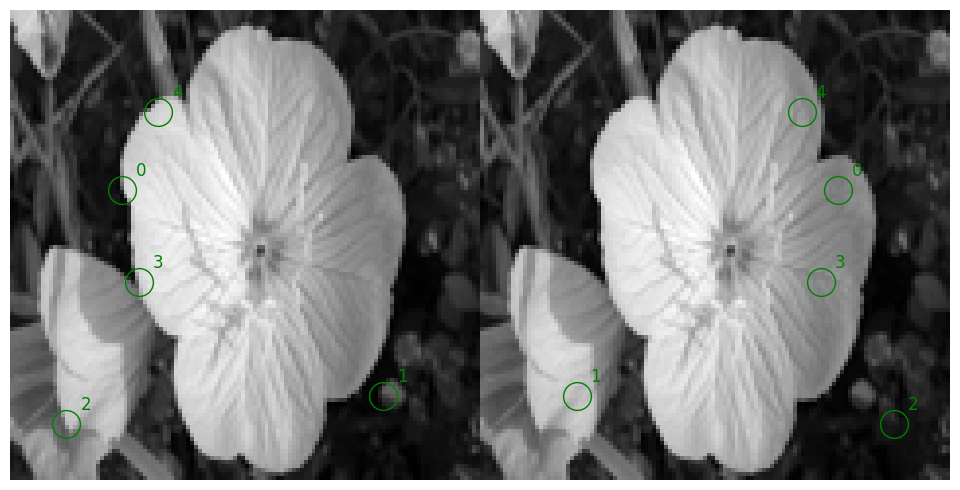

torch.Size([1, 83, 2]) torch.Size([1, 83, 2]) <class 'torch.Tensor'>
(1, 83, 2) (1, 83, 2)
Quant. de correspondecias Posicionais: 12
Fundamental Matrix:
[[ 1.36182818e-02  2.11122220e-02 -3.59722105e+00]
 [-2.17421816e-02 -2.66899314e-03  1.77480781e+00]
 [ 2.42623831e+00 -1.25902909e+00  1.00000000e+00]]
Correspondencias sem outliers 7
tensor([[ 94.4379,  33.3728],
        [ 86.6272, 101.5385],
        [ 76.6864,  24.8521],
        [ 68.8757,  17.7515],
        [ 86.6272,  41.1834]], grad_fn=<SliceBackward0>)
Erro ao plotar correspondencias


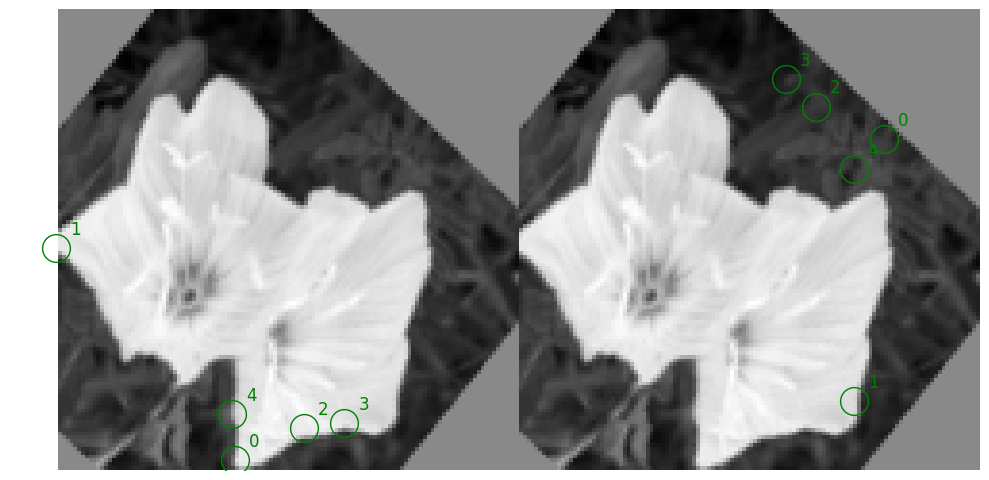

torch.Size([1, 100, 2]) torch.Size([1, 100, 2]) <class 'torch.Tensor'>
(1, 100, 2) (1, 100, 2)
Quant. de correspondecias Posicionais: 10
Fundamental Matrix:
[[ 8.26097401e-05  1.69047519e-03 -9.33711876e-02]
 [-1.62251622e-03  8.27519045e-05  5.02952211e-02]
 [ 7.92802289e-02 -6.85676876e-02  1.00000000e+00]]
Correspondencias sem outliers 7
tensor([[ 95.1479,  27.6923],
        [ 60.3550,  15.6213],
        [ 76.6864,  17.0414],
        [ 95.1479,  18.4615],
        [ 76.6864, 105.0888]], grad_fn=<SliceBackward0>)
Erro ao plotar correspondencias


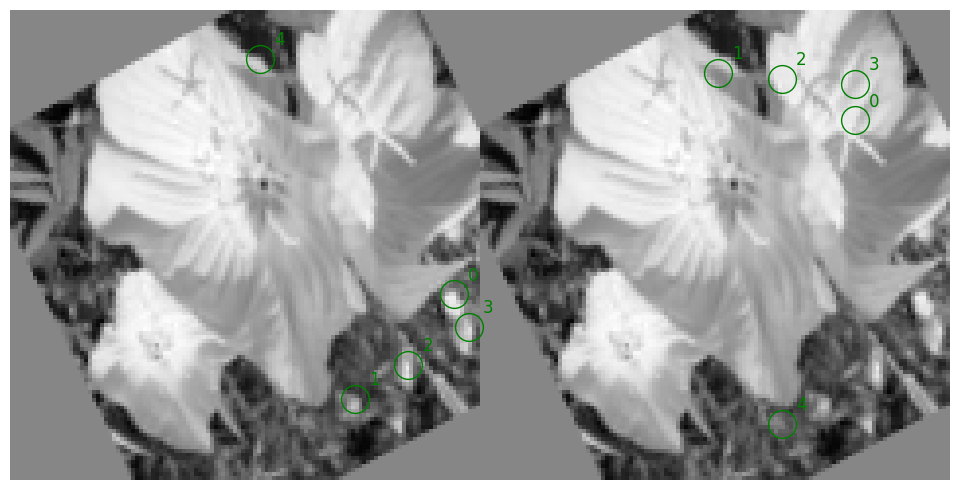

torch.Size([1, 96, 2]) torch.Size([1, 96, 2]) <class 'torch.Tensor'>
(1, 96, 2) (1, 96, 2)
Quant. de correspondecias Posicionais: 7
Fundamental Matrix:
[[ 5.09462924e-05 -2.55892742e-03  1.31798415e-01]
 [ 2.58798889e-03  2.40997468e-04 -2.91916348e-01]
 [-1.39609052e-01  2.61873528e-01  1.00000000e+00]]
Correspondencias sem outliers 7
tensor([[107.9290,  66.0355],
        [ 66.0355,  68.8757],
        [ 53.2544,  95.8580],
        [ 97.2781,  71.0059],
        [ 91.5976,  27.6923]], grad_fn=<SliceBackward0>)
Erro ao plotar correspondencias


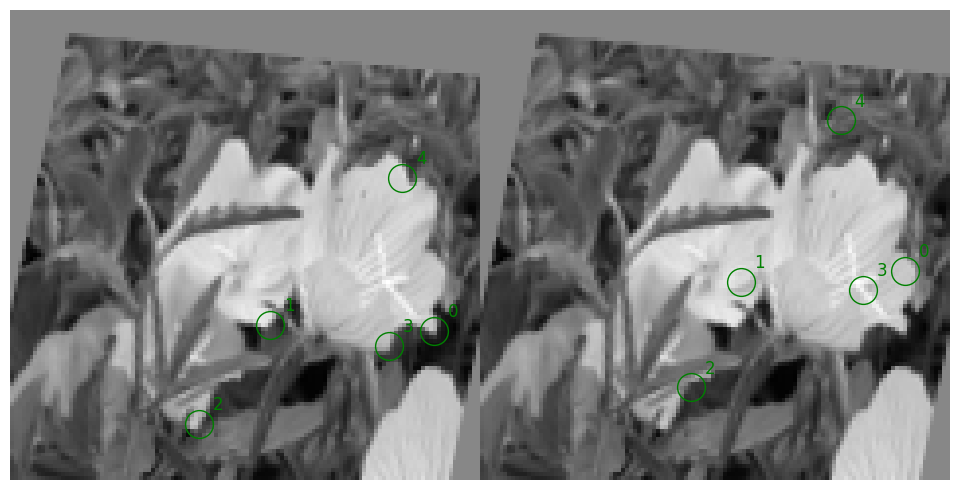

torch.Size([1, 106, 2]) torch.Size([1, 106, 2]) <class 'torch.Tensor'>
(1, 106, 2) (1, 106, 2)
Quant. de correspondecias Posicionais: 5
Fundamental Matrix:
None


AttributeError: 'NoneType' object has no attribute 'ravel'

In [33]:
import torch
import kornia.feature as KF
import torchvision
from torchvision.transforms import transforms, InterpolationMode
import kornia_moons.feature as KMF
import kornia.augmentation as KA
import matplotlib.pyplot as plt

def detect_and_match(first_batch,second_batch,keynet_hardnet,matcher):
    laf1, _, desc1 = keynet_hardnet(first_batch)
    laf2, _, desc2 = keynet_hardnet(second_batch)
    
    
    kp1 =laf_to_xy(laf1.detach().numpy())
    kp2 =laf_to_xy(laf2.detach().numpy())
    
    # print(laf1.shape,kp1.shape,desc1.shape)
    
    # Remove a dimensão extra dos descritores
    desc1 = desc1[0]
    desc2 = desc2[0]
    
    # Realiza a correspondência dos descritores
    dist,matches = matcher(desc1, desc2)
    # print(dist.shape,matches.shape)
    
    return kp1,kp2,matches

transform2 = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((120,120), interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

trainset = torchvision.datasets.Flowers102(root='./data/datasets', split='train',
                                        download=True, transform=transform2)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1,
                                        shuffle=False, num_workers=2)

keynet_hardnet = KF.KeyNetHardNet()
matcher = KF.DescriptorMatcher('snn', 0.5)
seed_everything()

for data in trainloader:
    first_batch,_ = data
    laf1, _, desc1 = keynet_hardnet(first_batch)
    kp1 =laf_to_xy(laf1)

    second_batch, keypoints_trans = data_augmentation(first_batch, kp1)  # Realizar transformações de aumento de dados
    laf2, _, desc2 = keynet_hardnet(first_batch)
    kp2 =laf_to_xy(laf2)
    
    print(keypoints_trans.shape,kp2.shape,type(keypoints_trans))
    evaluates_repeatability(keypoints_trans.detach().numpy(),kp2.detach().numpy())
    print(kp1[0,:5].cpu())
   

In [35]:
import cv2
import numpy as np

def find_matching_points(keypoints1, keypoints2, threshold):
    matches = []
    
    for i, kp1 in enumerate(keypoints1):
        best_match = None
        best_distance = float('inf')
        
        for j, kp2 in enumerate(keypoints2):
            distance = np.linalg.norm(np.array(kp1.pt) - np.array(kp2.pt))
            
            if distance < best_distance:
                best_distance = distance
                best_match = j
        
        if best_distance < threshold:
            matches.append(cv2.DMatch(i, best_match, best_distance))
    
    return matches


# Exemplo de uso
# keypoints1 e keypoints2 são listas de keypoints usando a estrutura cv2.KeyPoint do OpenCV
keypoints1 = [cv2.KeyPoint(10, 20, 1.0), cv2.KeyPoint(30, 40, 1.0), cv2.KeyPoint(50, 60, 1.0)]
keypoints2 = [cv2.KeyPoint(12, 22, 1.0), cv2.KeyPoint(28, 38, 1.0), cv2.KeyPoint(55, 65, 1.0)]
threshold = 10.0

matches = find_matching_points(keypoints1, keypoints2, threshold)

# Imprimir correspondências encontradas
for match in matches:
    print(f"Keypoint 1: {match.queryIdx}, Keypoint 2: {match.trainIdx}, Distance: {match.distance}")


Keypoint 1: 0, Keypoint 2: 0, Distance: 2.8284270763397217
Keypoint 1: 1, Keypoint 2: 1, Distance: 2.8284270763397217
Keypoint 1: 2, Keypoint 2: 2, Distance: 7.071067810058594


In [38]:
import cv2
import numpy as np

def find_matching_points(keypoints1, keypoints2, threshold):
    # Converter os keypoints em matrizes NumPy com tipo CV_32F
    keypoints1_np = np.array([kp.pt for kp in keypoints1], dtype=np.float32)
    keypoints2_np = np.array([kp.pt for kp in keypoints2], dtype=np.float32)

    # Inicializar o matcher de força bruta
    matcher = cv2.BFMatcher(cv2.NORM_L2)  # Usando a métrica de distância L2

    # Encontrar correspondências entre os keypoints
    matches = matcher.match(keypoints1_np, keypoints2_np)

    # Filtrar correspondências com base no threshold
    good_matches = [match for match in matches if match.distance < threshold]

    return good_matches

# Exemplo de uso
keypoints1 = [cv2.KeyPoint(10, 20, 1.0), cv2.KeyPoint(30, 40, 1.0), cv2.KeyPoint(50, 60, 1.0)]
keypoints2 = [cv2.KeyPoint(12, 22, 1.0), cv2.KeyPoint(28, 38, 1.0), cv2.KeyPoint(55, 65, 1.0)]
threshold = 10.0

matches = find_matching_points(keypoints1, keypoints2, threshold)

# Imprimir correspondências encontradas
for match in matches:
    print(match.queryIdx, match.trainIdx, match.distance)


0 0 2.8284270763397217
1 1 2.8284270763397217
2 2 7.071067810058594
